# DTMのコードの関数作成
* time_sliceの作成
 * 年月別ユーザー数でtime_sliceを作成する
* 上記で作成した年月別ユーザー数をリスト化する
* corpus作成のデータ準備
 * ユーザーの年月別購買商品を取得する
 * リスト化
 * ※ここで、ユーザーIDとユーザーの購買履歴を対応づける作業を行う。
* DTMのデータ準備
 * cat4の辞書の作成
 * corpus作成
* DTM実装
 * トピック数を指定する
 * モデルを実行し、モデルを保存する
* DTM結果の可視化
 * 各トピックの年月別割合推移を可視化する
 * サンキーダイアグラムを用いて


In [4]:
pip install japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
target_data_food = pd.read_csv("conv_cat1_food_data_target_user10_2500.csv", index_col=0)

In [3]:
target_data_food.columns

Index(['receipt_num', 'receipt_buydate', 'G_gyoutai_name', 'cat1', 'cat4',
       'id'],
      dtype='object')

In [4]:
#日付データの形式変更
target_data_food['receipt_buydate'] = pd.to_datetime(target_data_food['receipt_buydate'])

In [5]:
pip install gensim nltk

Note: you may need to restart the kernel to use updated packages.


# classを使ってdtmの前処理を記述

In [6]:
from gensim import corpora, models
import pandas as pd

class Pre_dtm:
    def __init__(self, target_data_food):
        self.target_data_food = target_data_food
        self.user_time_slice = None
        self.user_cat4_ym = None
        self.indices_by_id = None
        self.dictionary = None
        self.corpus = None

    def create_time_slice(self):
        unique_user_count = self.target_data_food.groupby(self.target_data_food['receipt_buydate'].dt.to_period("M"))['id'].nunique().reset_index()
        unique_user_count.columns = ['receipt_buydate', 'unique_user_count']
        self.user_time_slice = unique_user_count['unique_user_count'].tolist()
        return self.user_time_slice

    def prepare_corpus_data(self):
        grouped_cat4_data = self.target_data_food.groupby([self.target_data_food['receipt_buydate'].dt.to_period("M"), 'id'])['cat4'].apply(lambda x: [product.strip() for product in x]).reset_index()
        self.user_cat4_ym = grouped_cat4_data['cat4'].tolist()
        date_range = pd.date_range(start='2014-04-01', end='2015-03-31', freq='M').strftime('%Y-%m').tolist()
        self.indices_by_id = grouped_cat4_data.groupby('id').apply(lambda group: [group[group['receipt_buydate'].dt.strftime('%Y-%m') == month].index[0].tolist() if month in group['receipt_buydate'].dt.strftime('%Y-%m').tolist() else 'NA' for month in date_range])

        return self.user_cat4_ym, self.indices_by_id

    def create_dictionary(self):
        texts = self.target_data_food['cat4'].tolist()
        processed_docs = [[str(doc).lower().strip()] for doc in texts]
        self.dictionary = corpora.Dictionary(processed_docs)
        return self.dictionary

    def create_corpus(self):
        if self.dictionary is None:
            self.create_dictionary()
        if self.user_cat4_ym is None:
            self.prepare_corpus_data()
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.user_cat4_ym]
        return self.corpus

    def analyze(self):
        self.create_time_slice()
        self.prepare_corpus_data()
        self.create_dictionary()
        self.create_corpus()
        return {
            'time_slice': self.user_time_slice,
            'corpus_data': (self.user_cat4_ym, self.indices_by_id),
            'dictionary': self.dictionary,
            'corpus': self.corpus
        }

In [7]:
# Assuming you have your target_data_food DataFrame
analyzer = Pre_dtm(target_data_food)
results = analyzer.analyze()

# Access the results
user_time_slice = results['time_slice']
user_cat4_ym, indices_by_id = results['corpus_data']
dictionary = results['dictionary']
corpus = results['corpus']

# DTM実装

In [8]:
# #時系列でのトピックの確率を取得
#     for time in range(len(user_time_slice)):
#         topics_at_time_t = ldaseq.print_topics(time=time)
#         for topic_id, topic_prob in enumerate(topics_at_time_t):
#             print(topic_id, topic_prob[0:5])

In [9]:
results['time_slice']

[10207,
 10357,
 10111,
 10287,
 10369,
 10132,
 10250,
 9979,
 9911,
 10088,
 9864,
 10215]

In [31]:
from gensim.models import LdaSeqModel
import numpy as np
import datetime

# トピック数を指定,データのタイプを指定
num_topics = 10
data_type = 'conv'
def run_dtm(num_topics, user_time_slice, corpus, dictionary):
    ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=user_time_slice, num_topics=num_topics)
    ldaseq.save(f'dtm_cat4_{num_topics}_{data_type}.pkl')


def vis_dtm_result(user_time_slice, num_topic, data_type):
    #各トピックの年月別割合推移を可視化する
    cumulative_list = [sum(user_time_slice[:i+1]) for i in range(len(user_time_slice))]
    #モデルの読み込み
    ldaseq = LdaSeqModel.load(f'dtm_cat4_{num_topics}_{data_type}.pkl')
    # トピックの割合を計算
    time_topic_prob = {}
    start = 0
    for num, index in enumerate(cumulative_list):
        # 各トピックの確率を効率的に平均化
        topic_probs = np.mean(ldaseq.doc_topics(range(start,index)), axis = 0)

        # 結果を格納
        time_topic_prob[num] = topic_probs

        # 次の時間帯の開始点を更新
        start = index
    #可視化の際のインデックスを取得
    times_ = list(target_data_food['receipt_buydate'].dt.to_period("M").unique())
    times_ = [str(str_time) for str_time in times_]
    times_ = sorted(times_, key=lambda x: datetime.datetime.strptime(x, "%Y-%m"))

    # データの準備
    data = time_topic_prob
    # データを時間とトピック別に整理
    times = list(data.keys())
    topic_prob_data = [[data[t][s] for t in times] for s in range(num_topic)]
    for i in range(num_topic):
        plt.plot(times_, topic_prob_data[i],label=f'Topic{i}')
    # グラフのスタイリング
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Topic Proportion', fontsize=12)
    plt.title('Topic Evolution Over Time', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    # plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{data_type}propotion.png", dpi=700)
    plt.show()
    print(topic_prob_data)
    print(data)

In [39]:
run_dtm(num_topics, user_time_slice, corpus, dictionary)

KeyboardInterrupt: 

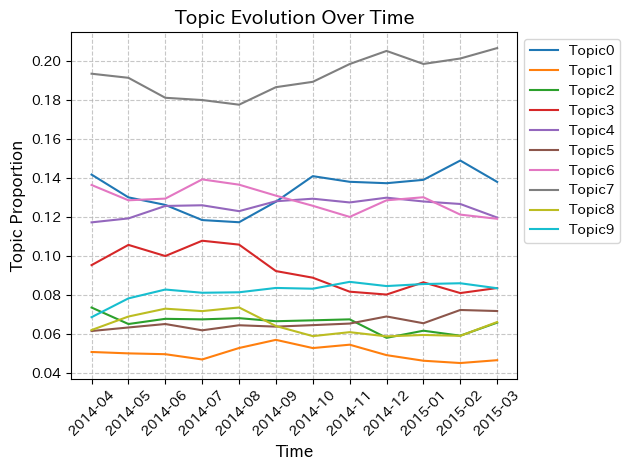

[[0.14172504400494218, 0.13003097008378686, 0.1261632424490156, 0.11837334597162624, 0.11725660351998002, 0.12779752745082448, 0.140925627960925, 0.1380241949111634, 0.13730409404939867, 0.1390318180894554, 0.14894853448696224, 0.1379722452600851], [0.05064025633217974, 0.04992367098750667, 0.049499440272961215, 0.04679472530821512, 0.05267879199420423, 0.05687176154942095, 0.052650384585771454, 0.05438080820806638, 0.049017549365831574, 0.04614514045654743, 0.044961780620993014, 0.04642414182818461], [0.07345742260559465, 0.06499595276745958, 0.06766299478129366, 0.0673851630543557, 0.06800225805762498, 0.06643152124003843, 0.06689324062305016, 0.06739034215999457, 0.057909892823787536, 0.06156022477977253, 0.05899911669257416, 0.06569837970929954], [0.09523815584994062, 0.10562924389042871, 0.09990625952296153, 0.10776455203497928, 0.10576860148193869, 0.09218596317909297, 0.0887795561040005, 0.08160143844187336, 0.08013119054480614, 0.08640241712167972, 0.0808910246954022, 0.0834862

In [33]:
vis_dtm_result(user_time_slice, num_topics, data_type)

In [11]:
ldaseq = LdaSeqModel.load('dtm_cat4_10_conv.pkl')
#時系列でのトピックの確率を取得
tmp_dic = {}
for time in range(len(user_time_slice)):
    topics_at_time_t = ldaseq.print_topics(time=time)
    for topic_id, topic_prob in enumerate(topics_at_time_t):
        print(topic_id, topic_prob[0:5])
        tmp_dic[topic_id] = topic_prob[0:5]
pd.DataFrame(tmp_dic)

0 [('チョコレ－ト', 0.2999184503663558), ('スナック', 0.2710493740397424), ('煎餅・あられ', 0.12026986613513556), ('ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-', 0.11520456069461506), ('キャンディ', 0.046663729591567955)]
1 [('コ－ヒ－ドリンク', 0.9348607825226632), ('野菜ジユ－ス', 0.01473584785615196), ('チュ－インガム', 0.009065046231170631), ('栄養ドリンク', 0.005135859104746029), ('豆乳', 0.004141949659338347)]
2 [('液体茶', 0.9609986384738427), ('キャンディ', 0.0028796002584152063), ('ドレッシング', 0.0025225954485911476), ('スポ－ツドリンク', 0.0022749965961077014), ('チュ－インガム', 0.0017176586633119465)]
3 [('アイスクリ－ム', 0.5725154422637801), ('キャンディ', 0.2719903933301626), ('チュ－インガム', 0.08876649910583695), ('デザ－ト類', 0.024006357843453514), ('玩具メ－カ－菓子', 0.006993837851279728)]
4 [('牛乳', 0.16929809296092016), ('食パン', 0.115039672679483), ('冷凍調理', 0.09822651091825849), ('洋風食品', 0.07195965801622689), ('ヨ－グルト', 0.04081275963995875)]
5 [('ビ－ル', 0.34738666049481065), ('その他酒類', 0.20834860910525563), ('つまみ類', 0.15458232261057528), ('焼酎', 0.043529519468540126), ('日本酒', 0.03351688337648834)]
6 [('ヨ－

,0,1,2,3,4,5,6,7,8,9
0,"(チョコレ－ト, 0.2978937356141824)","(コ－ヒ－ドリンク, 0.9366760857326745)","(液体茶, 0.9636692951979667)","(アイスクリ－ム, 0.4850224813189015)","(牛乳, 0.12075891724577141)","(ビ－ル, 0.37839993508611364)","(ヨ－グルト, 0.18018409078690056)","(菓子パン・調理パン, 0.911982186067206)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.2795715067391005)","(たばこ, 0.9802228945373933)"
1,"(スナック, 0.29399100595407235)","(野菜ジユ－ス, 0.01579270177146925)","(ドレッシング, 0.0022824268029816904)","(キャンディ, 0.3382802564210447)","(食パン, 0.1100344152276754)","(その他酒類, 0.18462590255784464)","(紅茶ドリンク, 0.12190830318921408)","(食パン, 0.04808329362154153)","(ミネラルウォ－タ類, 0.20306801137743055)","(チュ－インガム, 0.0009190020776081669)"
2,"(煎餅・あられ, 0.11556568084954966)","(チュ－インガム, 0.007251805551244751)","(キャンディ, 0.002269671852009707)","(チュ－インガム, 0.09496907576806661)","(冷凍調理, 0.10800535569204714)","(つまみ類, 0.1414723297005582)","(栄養ドリンク, 0.09442783939973712)","(牛乳, 0.010191627913799045)","(コ－ラ, 0.17516331962865958)","(煮干し, 0.0009179821510005957)"
3,"(ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-, 0.11541340881824938)","(栄養ドリンク, 0.00366245878916727)","(スポ－ツドリンク, 0.0017038060637815729)","(デザ－ト類, 0.020032092364843056)","(洋風食品, 0.0974651607863033)","(焼酎, 0.04180793477034445)","(牛乳, 0.09140263854472058)","(デザ－ト類, 0.005316998549129812)","(炭酸飲料, 0.11900785158790698)","(本みりん, 0.000917982048469818)"
4,"(つまみ類, 0.05178993574280063)","(果汁飲料, 0.0033933619013317385)","(紅茶ドリンク, 0.0015262413615216115)","(豆乳, 0.018092627034965867)","(その他調理食品, 0.05684663677436552)","(日本酒, 0.041643282591616815)","(野菜ジユ－ス, 0.08395578336600379)","(その他菓子, 0.0030148792324557684)","(サイダ－, 0.0598353027649179)","(その他食品, 0.0009179820111305571)"


In [28]:
# 年月リスト（例: 2014年4月～2015年3月）
time_labels = pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()

# 検証用: 出力する全データを保持するリスト
all_rows = []

# トピックデータの処理とラベル付け
for time, label in enumerate(time_labels):
    topics_at_time_t = ldaseq.print_topics(time=time)  # 各タイムスライスのトピックを取得
    rows = []
    for topic_id, topic in enumerate(topics_at_time_t):
        # トピックごとのデータ整形
        row = {"年月": label, "トピック": topic_id}
        for rank, (word, prob) in enumerate(topic[:5], start=1):  # 上位5つを取得
            row[f"{rank} 位"] = f"{word} ({prob:.3f})"
        rows.append(row)
    all_rows.extend(rows)  # 全タイムスライスのデータをまとめる

# データフレーム化
df = pd.DataFrame(all_rows)
output_file = "dtm_topic/dtm_topic_conv.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

# サンキーダイアグラムの可視化

In [34]:
indices_by_id

id
0.0        [0, 10207, 20564, 30675, 40962, NA, 61463, 717...
2.0        [NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, 1...
4.0        [1, 10208, 20565, 30676, 40963, 51331, 61464, ...
6.0        [NA, 10209, NA, NA, 40964, 51332, 61465, 71715...
8.0        [2, 10210, 20566, 30677, 40965, 51333, 61466, ...
                                 ...                        
40338.0    [10204, 20561, 30673, 40959, 51328, 61460, 717...
40343.0    [NA, NA, NA, 40960, 51329, 61461, NA, 81689, N...
40344.0    [10205, 20562, 30674, 40961, 51330, 61462, 717...
40349.0    [NA, 20563, NA, NA, NA, NA, NA, NA, NA, NA, 11...
40350.0    [10206, NA, NA, NA, NA, NA, NA, 81691, NA, NA,...
Length: 15078, dtype: object

In [35]:
from collections import defaultdict
import numpy as np

def analyze_cluster_transitions(indices_by_id, ldaseq):
    def create_user_cluster_dict(indices_by_id, ldaseq):
        # indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        # indices_by_id.columns = ['id', 'doc_list']
        # user_cluster_dic = {}
        # for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
        #     clus_list = []
        #     num = 0
        #     for doc_num in doc_list:
        #         bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
        #         clus_list.append(f'{bel_ind}_{num}')
        #         num += 1
        #     user_cluster_dic[id] = clus_list
        user_cluster_dic={}
        indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        indices_by_id.columns = ['id', 'doc_list']
        for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
            clus_list = []
            num = 0
            for doc_num in doc_list:
                if doc_num == 'NA':
                    clus_list.append(f'{100}_{num}')
                else:
                    bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
                    clus_list.append(f'{bel_ind}_{num}')
                num += 1
            user_cluster_dic[id] = clus_list
        return user_cluster_dic

    def count_transitions(cluster_sequences):
        transition_counts = defaultdict(int)
        for cluster_sequence in cluster_sequences:
            for i in range(len(cluster_sequence) - 1):
                current_cluster = cluster_sequence[i]
                next_cluster = cluster_sequence[i + 1]
                transition = (current_cluster, next_cluster)
                transition_counts[transition] += 1
        return transition_counts

    def prepare_sankey_data(transition_counts):
        source = []
        target = []
        values_list = []
        for item, value in transition_counts.items():
            source.append(item[0])
            target.append(item[1])
            values_list.append(value)
        return source, target, values_list

    user_cluster_dic = create_user_cluster_dict(indices_by_id, ldaseq)
    cluster_sequences = user_cluster_dic.values()
    transition_counts = count_transitions(cluster_sequences)

    # 結果の出力
    for transition, count in transition_counts.items():
        print(f"遷移 {transition} は {count} 回発生しました。")

    source, target, values_list = prepare_sankey_data(transition_counts)

    return user_cluster_dic, transition_counts, source, target, values_list


In [36]:
# indices_by_id と ldaseq が既に定義されていると仮定
user_cluster_dic, transition_counts, source, target, values_list = analyze_cluster_transitions(indices_by_id, ldaseq)

# 返された値を使って後続の処理を行う
# 例: サンキーダイアグラムの作成など

遷移 ('6_0', '6_1') は 436 回発生しました。
遷移 ('6_1', '4_2') は 90 回発生しました。
遷移 ('4_2', '6_3') は 106 回発生しました。
遷移 ('6_3', '6_4') は 482 回発生しました。
遷移 ('6_4', '100_5') は 246 回発生しました。
遷移 ('100_5', '6_6') は 201 回発生しました。
遷移 ('6_6', '6_7') は 431 回発生しました。
遷移 ('6_7', '100_8') は 167 回発生しました。
遷移 ('100_8', '2_9') は 121 回発生しました。
遷移 ('2_9', '4_10') は 31 回発生しました。
遷移 ('4_10', '100_11') は 220 回発生しました。
遷移 ('100_0', '100_1') は 3026 回発生しました。
遷移 ('100_1', '100_2') は 3139 回発生しました。
遷移 ('100_2', '100_3') は 3140 回発生しました。
遷移 ('100_3', '100_4') は 3030 回発生しました。
遷移 ('100_4', '100_5') は 3102 回発生しました。
遷移 ('100_5', '100_6') は 3195 回発生しました。
遷移 ('100_6', '100_7') は 3268 回発生しました。
遷移 ('100_7', '100_8') は 3413 回発生しました。
遷移 ('100_8', '100_9') は 3334 回発生しました。
遷移 ('100_9', '100_10') は 3353 回発生しました。
遷移 ('100_10', '3_11') は 186 回発生しました。
遷移 ('9_0', '9_1') は 614 回発生しました。
遷移 ('9_1', '9_2') は 722 回発生しました。
遷移 ('9_2', '9_3') は 730 回発生しました。
遷移 ('9_3', '9_4') は 733 回発生しました。
遷移 ('9_4', '9_5') は 749 回発生しました。
遷移 ('9_5', '9_6') は 740 回発生しました。
遷移 ('9_6',

## 遷移行列とエントロピー

In [37]:
#遷移行列を作成するためのコード
transtion_data = []
for (from_state,to_state), count in transition_counts.items():
    cluster_f, time_f = from_state.split('_')
    cluster_t, time_t = to_state.split('_')
    if cluster_f == "100" and cluster_t == "100":
        from_state = f'10_{time_f}'
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_f == "100":
        from_state = f'10_{time_f}'
        transtion_data.append((from_state, to_state, count))
    elif cluster_t == "100":
        to_state = f'10_{time_t}'
        transtion_data.append((from_state, to_state, count))
    else:
        transtion_data.append((from_state, to_state, count))


In [38]:
transtion_data

[('6_0', '6_1', 436),
 ('6_1', '4_2', 90),
 ('4_2', '6_3', 106),
 ('6_3', '6_4', 482),
 ('6_4', '10_5', 246),
 ('10_5', '6_6', 201),
 ('6_6', '6_7', 431),
 ('6_7', '10_8', 167),
 ('10_8', '2_9', 121),
 ('2_9', '4_10', 31),
 ('4_10', '10_11', 220),
 ('10_0', '10_1', 3026),
 ('10_1', '10_2', 3139),
 ('10_2', '10_3', 3140),
 ('10_3', '10_4', 3030),
 ('10_4', '10_5', 3102),
 ('10_5', '10_6', 3195),
 ('10_6', '10_7', 3268),
 ('10_7', '10_8', 3413),
 ('10_8', '10_9', 3334),
 ('10_9', '10_10', 3353),
 ('10_10', '3_11', 186),
 ('9_0', '9_1', 614),
 ('9_1', '9_2', 722),
 ('9_2', '9_3', 730),
 ('9_3', '9_4', 733),
 ('9_4', '9_5', 749),
 ('9_5', '9_6', 740),
 ('9_6', '9_7', 774),
 ('9_7', '9_8', 737),
 ('9_8', '9_9', 717),
 ('9_9', '9_10', 749),
 ('9_10', '9_11', 772),
 ('10_0', '4_1', 232),
 ('4_1', '10_2', 226),
 ('10_3', '4_4', 225),
 ('4_4', '6_5', 81),
 ('6_5', '3_6', 70),
 ('3_6', '4_7', 59),
 ('4_7', '6_8', 85),
 ('6_8', '8_9', 40),
 ('8_9', '0_10', 45),
 ('0_10', '4_11', 115),
 ('8_0', '8

In [39]:
import pandas as pd
from collections import defaultdict

def create_time_dependent_transition_matrices(data):
    """
    時点ごとの遷移行列を作成する関数
    
    :param data: (from_state, to_state, count) の形式のデータリスト
    :return: 時点ごとの遷移行列を含む辞書
    """
    # クラスタと時点の情報を抽出
    all_clusters = set()
    all_timepoints = set()
    for from_state, to_state, _ in data:
        from_cluster, from_time = from_state.split('_')
        to_cluster, to_time = to_state.split('_')
        all_clusters.update([int(from_cluster), int(to_cluster)])
        all_timepoints.update([int(from_time), int(to_time)])
    
    num_clusters = 11
    num_timepoints = max(all_timepoints) + 1
    
    # 時点ごとの遷移回数を格納する辞書を初期化
    transition_counts = defaultdict(lambda: np.zeros((num_clusters, num_clusters)))
    
    # データから遷移回数を集計
    for from_state, to_state, count in data:
        from_cluster, from_time = map(int, from_state.split('_'))
        to_cluster, to_time = map(int, to_state.split('_'))
        if from_time + 1 == to_time:  # 連続する時点間の遷移のみを考慮
            transition_counts[from_time][from_cluster, to_cluster] += count
    
    # 遷移確率行列を計算
    transition_matrices = {}
    for time, counts in transition_counts.items():
        row_sums = counts.sum(axis=1)
        row_sums[row_sums == 0] = 1  # ゼロ除算を避ける
        transition_matrices[time] = counts / row_sums[:, np.newaxis]
    
    return transition_matrices

In [40]:
transition_matrices = create_time_dependent_transition_matrices(transtion_data)

In [41]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



時点 0 から 1 への遷移行列:
各状態のエントロピー：[2.18354519 1.4979262  1.79063331 2.18131386 2.0436712  1.64873102
 2.12018503 2.14337573 1.88847214 1.17758759 2.223483  ]

全体のエントロピー1.8999022060176882
      0     1     2     3     4     5     6     7     8     9     10
0  0.309 0.021 0.032 0.084 0.078 0.033 0.086 0.116 0.038 0.033 0.170
1  0.060 0.356 0.040 0.053 0.058 0.035 0.065 0.086 0.035 0.047 0.165
2  0.062 0.037 0.295 0.050 0.056 0.037 0.078 0.095 0.053 0.012 0.223
3  0.101 0.017 0.027 0.255 0.064 0.039 0.090 0.113 0.039 0.018 0.238
4  0.081 0.011 0.028 0.069 0.378 0.027 0.076 0.105 0.025 0.024 0.175
5  0.077 0.017 0.026 0.054 0.080 0.413 0.043 0.070 0.037 0.049 0.133
6  0.073 0.030 0.041 0.080 0.069 0.033 0.331 0.105 0.048 0.020 0.171
7  0.076 0.018 0.019 0.047 0.070 0.019 0.068 0.476 0.017 0.027 0.162
8  0.116 0.027 0.048 0.068 0.050 0.041 0.084 0.116 0.273 0.030 0.146
9  0.027 0.020 0.005 0.020 0.019 0.022 0.019 0.042 0.011 0.760 0.056
10 0.050 0.014 0.026 0.056 0.048 0.020 0.041 0.086 0.020 0

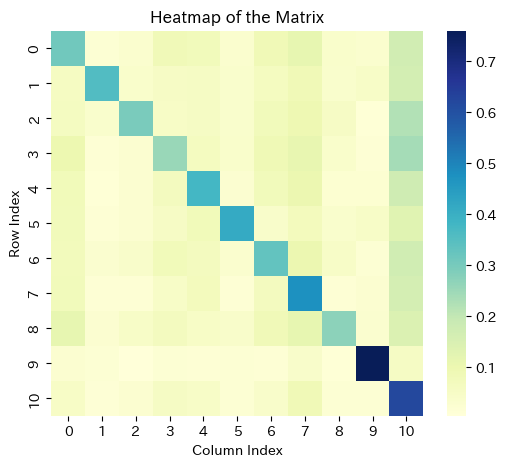


時点 1 から 2 への遷移行列:
各状態のエントロピー：[2.13122057 1.51765652 1.86539259 2.15389496 2.03238634 1.6244681
 2.1076265  2.10439936 1.90303521 1.01775835 2.22520364]

全体のエントロピー1.8802765570869353
      0     1     2     3     4     5     6     7     8     9     10
0  0.330 0.017 0.035 0.066 0.062 0.038 0.079 0.118 0.044 0.017 0.195
1  0.042 0.329 0.042 0.061 0.052 0.019 0.073 0.108 0.059 0.049 0.167
2  0.078 0.032 0.323 0.047 0.057 0.042 0.069 0.068 0.056 0.017 0.211
3  0.104 0.019 0.041 0.260 0.073 0.028 0.088 0.112 0.036 0.011 0.229
4  0.075 0.007 0.032 0.054 0.381 0.038 0.081 0.110 0.027 0.016 0.179
5  0.064 0.017 0.051 0.050 0.054 0.440 0.042 0.042 0.053 0.031 0.156
6  0.083 0.029 0.045 0.056 0.072 0.031 0.351 0.107 0.029 0.013 0.186
7  0.064 0.019 0.018 0.049 0.077 0.025 0.069 0.447 0.027 0.019 0.186
8  0.073 0.031 0.071 0.069 0.048 0.054 0.101 0.067 0.283 0.029 0.176
9  0.027 0.018 0.010 0.028 0.026 0.023 0.021 0.036 0.009 0.748 0.054
10 0.045 0.015 0.024 0.040 0.049 0.021 0.043 0.070 0.015 0.

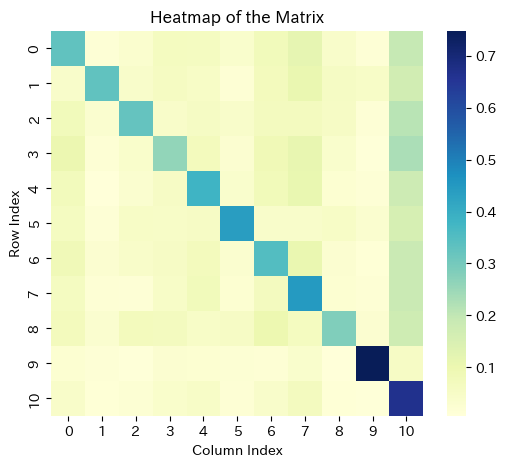


時点 2 から 3 への遷移行列:
各状態のエントロピー：[2.1203685  1.60294712 1.81718344 2.1223946  2.08684201 1.62209908
 2.11202642 2.11619164 1.84624387 1.02550488 2.22064417]

全体のエントロピー1.8811314292209678
      0     1     2     3     4     5     6     7     8     9     10
0  0.319 0.014 0.030 0.077 0.097 0.045 0.103 0.094 0.037 0.018 0.165
1  0.047 0.301 0.064 0.054 0.044 0.037 0.146 0.099 0.040 0.040 0.128
2  0.059 0.028 0.328 0.063 0.049 0.033 0.084 0.090 0.052 0.019 0.195
3  0.086 0.020 0.034 0.301 0.066 0.035 0.086 0.115 0.029 0.024 0.204
4  0.067 0.017 0.030 0.069 0.362 0.032 0.083 0.107 0.023 0.020 0.190
5  0.064 0.020 0.032 0.055 0.070 0.412 0.048 0.068 0.038 0.033 0.161
6  0.079 0.027 0.040 0.067 0.074 0.018 0.381 0.088 0.045 0.013 0.167
7  0.052 0.021 0.024 0.060 0.071 0.017 0.063 0.477 0.021 0.021 0.172
8  0.095 0.029 0.057 0.049 0.064 0.051 0.095 0.091 0.294 0.016 0.159
9  0.020 0.020 0.007 0.020 0.032 0.015 0.019 0.040 0.010 0.759 0.059
10 0.050 0.012 0.025 0.052 0.052 0.019 0.050 0.076 0.021 0

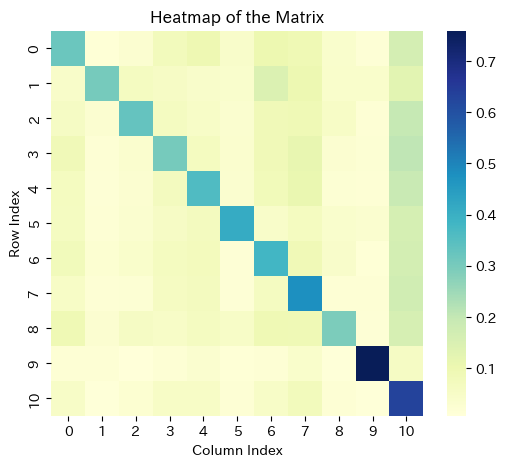


時点 3 から 4 への遷移行列:
各状態のエントロピー：[2.13824037 1.66731788 1.87803537 2.14979743 2.06240298 1.64602807
 2.154777   2.11842011 1.87803206 1.02497407 2.22745376]

全体のエントロピー1.9041344630863362
      0     1     2     3     4     5     6     7     8     9     10
0  0.323 0.021 0.032 0.081 0.066 0.032 0.084 0.104 0.045 0.015 0.197
1  0.060 0.326 0.057 0.049 0.055 0.031 0.078 0.076 0.044 0.039 0.185
2  0.070 0.033 0.314 0.072 0.048 0.025 0.091 0.092 0.046 0.013 0.196
3  0.104 0.025 0.037 0.271 0.076 0.035 0.088 0.094 0.036 0.017 0.218
4  0.070 0.017 0.026 0.054 0.364 0.037 0.081 0.112 0.029 0.027 0.183
5  0.065 0.017 0.031 0.045 0.071 0.416 0.065 0.083 0.036 0.031 0.141
6  0.083 0.044 0.041 0.076 0.071 0.036 0.344 0.095 0.043 0.016 0.152
7  0.051 0.021 0.024 0.063 0.077 0.025 0.068 0.474 0.022 0.021 0.153
8  0.085 0.049 0.059 0.068 0.049 0.047 0.088 0.090 0.288 0.022 0.156
9  0.026 0.016 0.017 0.015 0.027 0.016 0.026 0.038 0.008 0.748 0.063
10 0.042 0.015 0.029 0.049 0.047 0.022 0.048 0.080 0.021 0

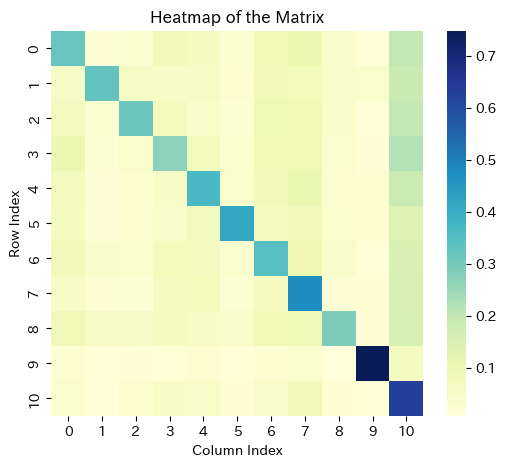


時点 4 から 5 への遷移行列:
各状態のエントロピー：[2.15482459 1.69173846 1.90773255 2.13516509 2.06455981 1.67607843
 2.14275725 2.1390654  1.79971859 1.02661906 2.23490846]

全体のエントロピー1.9066516079368194
      0     1     2     3     4     5     6     7     8     9     10
0  0.332 0.029 0.031 0.073 0.076 0.038 0.083 0.094 0.035 0.018 0.190
1  0.055 0.335 0.037 0.040 0.042 0.026 0.084 0.112 0.026 0.048 0.194
2  0.076 0.045 0.268 0.059 0.051 0.037 0.092 0.080 0.029 0.031 0.233
3  0.111 0.027 0.036 0.233 0.084 0.036 0.087 0.121 0.025 0.014 0.226
4  0.084 0.017 0.033 0.049 0.372 0.039 0.063 0.126 0.029 0.020 0.168
5  0.064 0.027 0.037 0.050 0.065 0.397 0.053 0.087 0.034 0.028 0.157
6  0.084 0.037 0.038 0.057 0.087 0.039 0.321 0.113 0.028 0.014 0.181
7  0.059 0.020 0.023 0.043 0.065 0.016 0.056 0.486 0.024 0.015 0.191
8  0.092 0.031 0.050 0.054 0.075 0.045 0.099 0.085 0.264 0.021 0.183
9  0.027 0.019 0.008 0.011 0.025 0.019 0.017 0.047 0.011 0.756 0.059
10 0.053 0.017 0.026 0.039 0.045 0.017 0.047 0.075 0.013 0

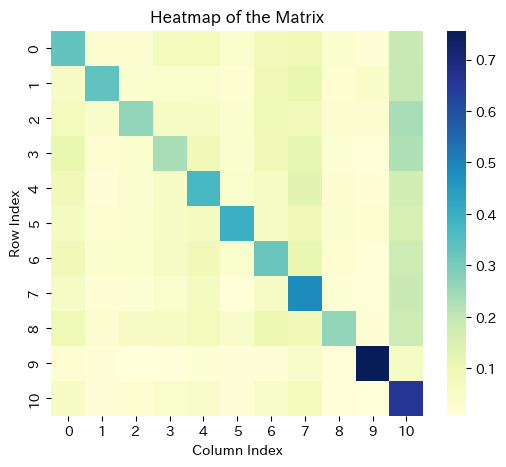


時点 5 から 6 への遷移行列:
各状態のエントロピー：[2.17496629 1.60587733 1.86350002 2.10615946 2.11141148 1.67589835
 2.15782868 2.09545236 1.67844908 1.0091886  2.2244246 ]

全体のエントロピー1.882105113310313
      0     1     2     3     4     5     6     7     8     9     10
0  0.359 0.019 0.029 0.073 0.082 0.031 0.074 0.123 0.020 0.021 0.169
1  0.067 0.325 0.062 0.050 0.048 0.032 0.097 0.075 0.018 0.042 0.183
2  0.065 0.035 0.319 0.044 0.076 0.037 0.087 0.089 0.027 0.015 0.206
3  0.112 0.015 0.041 0.254 0.081 0.035 0.107 0.122 0.020 0.015 0.200
4  0.091 0.018 0.035 0.050 0.356 0.034 0.082 0.116 0.024 0.022 0.172
5  0.094 0.015 0.026 0.054 0.071 0.416 0.068 0.057 0.017 0.042 0.140
6  0.115 0.041 0.055 0.056 0.079 0.032 0.309 0.100 0.033 0.014 0.166
7  0.074 0.018 0.021 0.040 0.075 0.027 0.062 0.499 0.014 0.015 0.155
8  0.112 0.042 0.059 0.040 0.068 0.053 0.080 0.078 0.247 0.013 0.209
9  0.031 0.020 0.011 0.016 0.023 0.020 0.012 0.043 0.007 0.755 0.060
10 0.056 0.011 0.025 0.040 0.051 0.022 0.041 0.079 0.016 0.

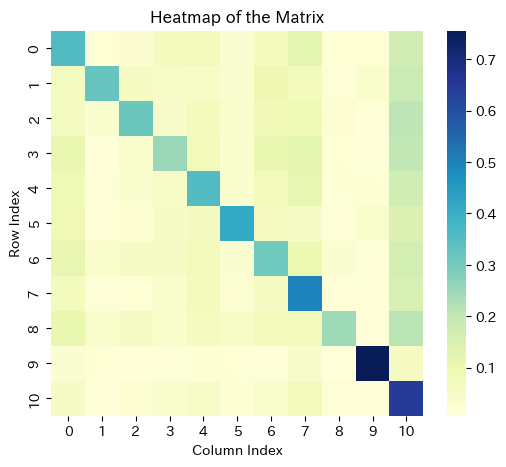


時点 6 から 7 への遷移行列:
各状態のエントロピー：[2.18091484 1.57581468 1.809486   2.106307   2.07381735 1.65894058
 2.06836736 2.11665006 1.789982   0.8884566  2.22921848]

全体のエントロピー1.8634504490147288
      0     1     2     3     4     5     6     7     8     9     10
0  0.325 0.021 0.033 0.064 0.072 0.038 0.090 0.112 0.030 0.020 0.195
1  0.082 0.380 0.027 0.045 0.055 0.027 0.082 0.075 0.032 0.032 0.164
2  0.073 0.065 0.312 0.035 0.046 0.039 0.085 0.088 0.039 0.011 0.207
3  0.143 0.027 0.035 0.201 0.068 0.039 0.081 0.118 0.042 0.009 0.237
4  0.086 0.016 0.025 0.033 0.354 0.028 0.071 0.154 0.024 0.016 0.193
5  0.079 0.025 0.037 0.022 0.074 0.410 0.040 0.071 0.031 0.027 0.184
6  0.084 0.030 0.040 0.060 0.062 0.034 0.354 0.109 0.034 0.013 0.179
7  0.067 0.023 0.023 0.035 0.072 0.025 0.050 0.489 0.016 0.018 0.183
8  0.088 0.028 0.054 0.049 0.073 0.041 0.073 0.104 0.282 0.018 0.189
9  0.025 0.015 0.011 0.014 0.021 0.019 0.018 0.030 0.010 0.779 0.056
10 0.051 0.014 0.025 0.030 0.048 0.017 0.032 0.079 0.016 0

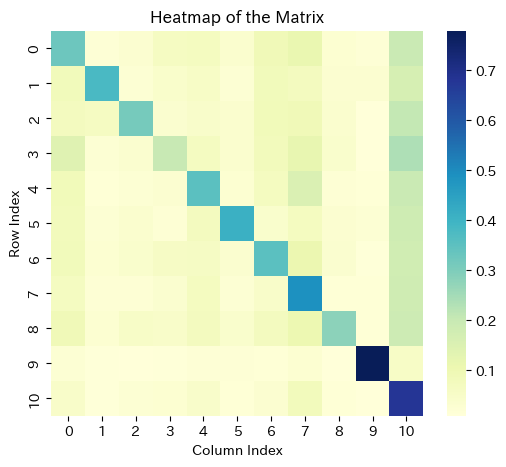


時点 7 から 8 への遷移行列:
各状態のエントロピー：[2.16647595 1.48123943 1.77016771 2.10219331 2.0596296  1.6158708
 2.06364824 2.14245558 1.76089333 0.96608819 2.23705198]

全体のエントロピー1.8514285560184751
      0     1     2     3     4     5     6     7     8     9     10
0  0.347 0.018 0.029 0.062 0.066 0.041 0.085 0.138 0.029 0.017 0.168
1  0.073 0.340 0.044 0.033 0.048 0.033 0.106 0.129 0.015 0.029 0.151
2  0.071 0.043 0.291 0.035 0.050 0.033 0.081 0.093 0.048 0.023 0.231
3  0.115 0.016 0.022 0.206 0.062 0.042 0.102 0.125 0.033 0.020 0.258
4  0.076 0.018 0.023 0.036 0.380 0.036 0.068 0.124 0.026 0.018 0.196
5  0.086 0.012 0.029 0.032 0.065 0.432 0.048 0.071 0.023 0.027 0.174
6  0.111 0.031 0.034 0.045 0.081 0.028 0.379 0.102 0.035 0.010 0.144
7  0.070 0.017 0.023 0.034 0.076 0.019 0.052 0.494 0.018 0.014 0.183
8  0.099 0.014 0.063 0.038 0.079 0.036 0.072 0.095 0.264 0.020 0.221
9  0.026 0.019 0.005 0.018 0.028 0.019 0.014 0.036 0.009 0.743 0.082
10 0.048 0.013 0.016 0.034 0.051 0.019 0.040 0.085 0.013 0.

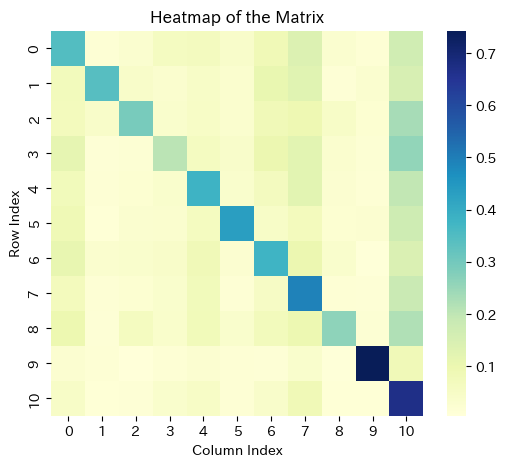


時点 8 から 9 への遷移行列:
各状態のエントロピー：[2.15231261 1.48524682 1.74521753 2.10149766 2.04787899 1.75695937
 2.14522659 2.12491118 1.70028276 1.04421539 2.22911816]

全体のエントロピー1.8666242782712361
      0     1     2     3     4     5     6     7     8     9     10
0  0.357 0.019 0.034 0.061 0.089 0.044 0.070 0.112 0.021 0.019 0.174
1  0.057 0.330 0.064 0.031 0.033 0.024 0.092 0.106 0.014 0.054 0.196
2  0.071 0.028 0.354 0.047 0.022 0.045 0.104 0.079 0.053 0.008 0.189
3  0.115 0.015 0.024 0.247 0.076 0.043 0.085 0.099 0.027 0.025 0.244
4  0.088 0.012 0.027 0.055 0.370 0.042 0.075 0.111 0.025 0.018 0.177
5  0.080 0.017 0.047 0.055 0.095 0.377 0.062 0.077 0.017 0.029 0.144
6  0.092 0.031 0.044 0.046 0.086 0.035 0.340 0.110 0.033 0.014 0.169
7  0.076 0.019 0.022 0.038 0.067 0.019 0.061 0.490 0.017 0.019 0.171
8  0.097 0.019 0.033 0.050 0.086 0.050 0.093 0.088 0.266 0.024 0.195
9  0.026 0.017 0.008 0.019 0.029 0.019 0.023 0.045 0.005 0.752 0.057
10 0.053 0.015 0.023 0.038 0.046 0.021 0.045 0.079 0.020 0

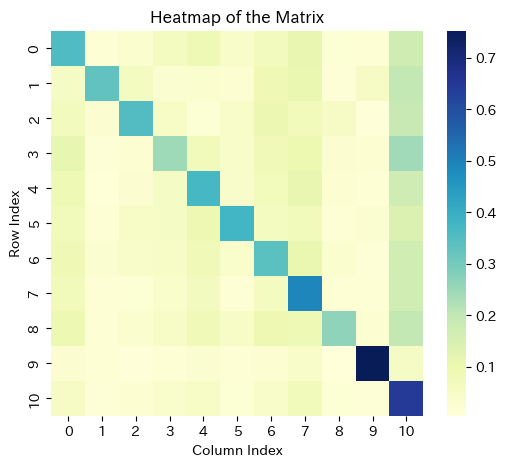


時点 9 から 10 への遷移行列:
各状態のエントロピー：[2.17898571 1.42201067 1.77961569 2.07652902 2.06726499 1.7116204
 2.07740704 2.16449715 1.75459441 1.05936054 2.24579374]

全体のエントロピー1.8670617589822773
      0     1     2     3     4     5     6     7     8     9     10
0  0.340 0.022 0.026 0.061 0.079 0.038 0.066 0.126 0.026 0.025 0.191
1  0.080 0.345 0.045 0.038 0.045 0.025 0.052 0.095 0.012 0.058 0.205
2  0.063 0.031 0.305 0.038 0.053 0.027 0.082 0.104 0.034 0.019 0.243
3  0.113 0.017 0.034 0.226 0.077 0.044 0.062 0.126 0.024 0.024 0.253
4  0.099 0.005 0.024 0.039 0.358 0.050 0.074 0.121 0.029 0.013 0.189
5  0.076 0.018 0.023 0.030 0.079 0.388 0.051 0.098 0.042 0.026 0.169
6  0.108 0.028 0.043 0.045 0.072 0.038 0.328 0.112 0.024 0.016 0.187
7  0.073 0.023 0.025 0.025 0.059 0.024 0.050 0.486 0.019 0.028 0.187
8  0.106 0.021 0.043 0.054 0.064 0.031 0.090 0.113 0.255 0.019 0.203
9  0.022 0.011 0.008 0.018 0.018 0.022 0.014 0.045 0.009 0.765 0.065
10 0.057 0.011 0.021 0.035 0.050 0.022 0.038 0.073 0.014 0

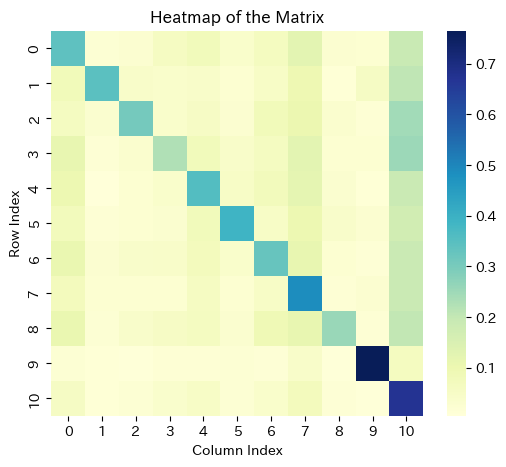


時点 10 から 11 への遷移行列:
各状態のエントロピー：[2.15511249 1.46148595 1.75888474 2.10177883 2.00873232 1.72682313
 2.05719098 2.18935364 1.86591027 1.0226066  2.21329318]

全体のエントロピー1.8691974670648284
      0     1     2     3     4     5     6     7     8     9     10
0  0.351 0.016 0.034 0.056 0.078 0.034 0.075 0.136 0.032 0.016 0.173
1  0.077 0.348 0.034 0.055 0.034 0.034 0.050 0.150 0.021 0.053 0.142
2  0.066 0.029 0.356 0.046 0.031 0.040 0.091 0.108 0.035 0.026 0.173
3  0.128 0.019 0.023 0.231 0.073 0.049 0.075 0.128 0.034 0.016 0.225
4  0.074 0.020 0.029 0.047 0.373 0.034 0.064 0.135 0.027 0.023 0.175
5  0.081 0.010 0.032 0.048 0.057 0.425 0.029 0.078 0.041 0.028 0.170
6  0.102 0.026 0.048 0.046 0.071 0.043 0.336 0.124 0.042 0.012 0.151
7  0.074 0.020 0.027 0.030 0.070 0.025 0.058 0.500 0.022 0.017 0.157
8  0.091 0.032 0.056 0.049 0.093 0.051 0.054 0.142 0.250 0.020 0.162
9  0.021 0.011 0.013 0.011 0.017 0.023 0.024 0.054 0.005 0.768 0.054
10 0.055 0.013 0.027 0.036 0.046 0.026 0.039 0.088 0.023

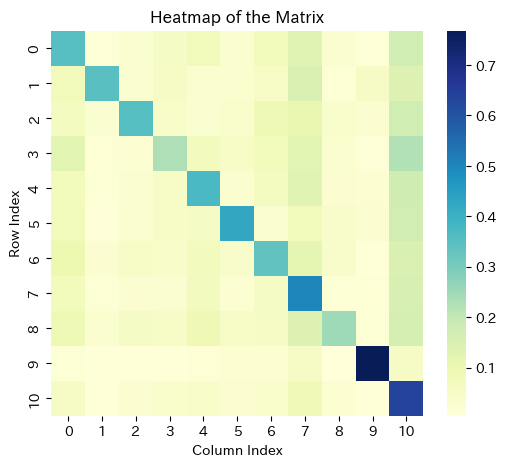

In [42]:
import seaborn as sns
from scipy.stats import entropy
# for time, matrix in transition_matrices.items():
#     df = pd.DataFrame(matrix).round(3)# 時点ごとの遷移行列を作成
# transition_matrices = create_time_dependent_transition_matrices(transtion_data)
# # 時系列ごとのエントロピーを格納するリストを作成
each_ento_list=[]
# # 全体のエントロピーを格納するためのリスト作成
all_ento_list=[]
# # 結果の表示
for time, matrix in transition_matrices.items():
    print(f"\n時点 {time} から {time+1} への遷移行列:")
    print(f"各状態のエントロピー：{entropy(matrix)}")
    
    #各時点のエントロピーのリストを作成
    each_ento_list.append(entropy(matrix))
    print()
    print(f"全体のエントロピー{np.mean(entropy(matrix))}")
    
    #全体平均エントロピーのリストを作成
    all_ento_list.append(np.mean(entropy(matrix)))
    df_tra = pd.DataFrame(matrix).round(3)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)       # 出力の横幅を200文字に設定
    pd.set_option('display.float_format', '{:.3f}'.format)  # 小数点以下3桁表示
    
    print(df_tra)
   
    plt.figure(figsize=(6, 5))
    matrix = pd.DataFrame(matrix)
    sns.heatmap(df_tra, annot=False ,cmap='YlGnBu')
    plt.title('Heatmap of the Matrix')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # ヒートマップの表示
    plt.show()



時点 0 から 1 への遷移行列:
各状態のエントロピー：[2.18354519 1.4979262  1.79063331 2.18131386 2.0436712  1.64873102
 2.12018503 2.14337573 1.88847214 1.17758759 2.223483  ]

全体のエントロピー1.8999022060176882
      0     1     2     3     4     5     6     7     8     9     10
0  0.309 0.021 0.032 0.084 0.078 0.033 0.086 0.116 0.038 0.033 0.170
1  0.060 0.356 0.040 0.053 0.058 0.035 0.065 0.086 0.035 0.047 0.165
2  0.062 0.037 0.295 0.050 0.056 0.037 0.078 0.095 0.053 0.012 0.223
3  0.101 0.017 0.027 0.255 0.064 0.039 0.090 0.113 0.039 0.018 0.238
4  0.081 0.011 0.028 0.069 0.378 0.027 0.076 0.105 0.025 0.024 0.175
5  0.077 0.017 0.026 0.054 0.080 0.413 0.043 0.070 0.037 0.049 0.133
6  0.073 0.030 0.041 0.080 0.069 0.033 0.331 0.105 0.048 0.020 0.171
7  0.076 0.018 0.019 0.047 0.070 0.019 0.068 0.476 0.017 0.027 0.162
8  0.116 0.027 0.048 0.068 0.050 0.041 0.084 0.116 0.273 0.030 0.146
9  0.027 0.020 0.005 0.020 0.019 0.022 0.019 0.042 0.011 0.760 0.056
10 0.050 0.014 0.026 0.056 0.048 0.020 0.041 0.086 0.020 0

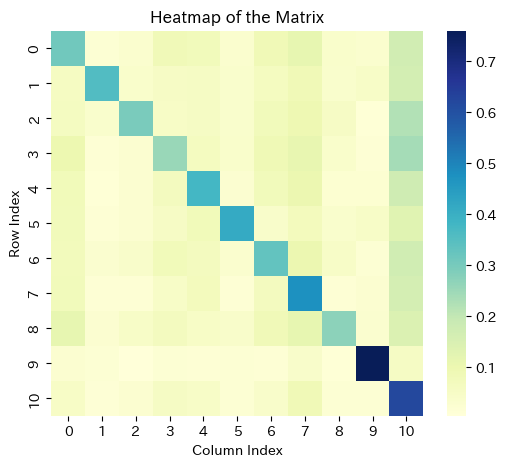


時点 1 から 2 への遷移行列:
各状態のエントロピー：[2.13122057 1.51765652 1.86539259 2.15389496 2.03238634 1.6244681
 2.1076265  2.10439936 1.90303521 1.01775835 2.22520364]

全体のエントロピー1.8802765570869353
      0     1     2     3     4     5     6     7     8     9     10
0  0.330 0.017 0.035 0.066 0.062 0.038 0.079 0.118 0.044 0.017 0.195
1  0.042 0.329 0.042 0.061 0.052 0.019 0.073 0.108 0.059 0.049 0.167
2  0.078 0.032 0.323 0.047 0.057 0.042 0.069 0.068 0.056 0.017 0.211
3  0.104 0.019 0.041 0.260 0.073 0.028 0.088 0.112 0.036 0.011 0.229
4  0.075 0.007 0.032 0.054 0.381 0.038 0.081 0.110 0.027 0.016 0.179
5  0.064 0.017 0.051 0.050 0.054 0.440 0.042 0.042 0.053 0.031 0.156
6  0.083 0.029 0.045 0.056 0.072 0.031 0.351 0.107 0.029 0.013 0.186
7  0.064 0.019 0.018 0.049 0.077 0.025 0.069 0.447 0.027 0.019 0.186
8  0.073 0.031 0.071 0.069 0.048 0.054 0.101 0.067 0.283 0.029 0.176
9  0.027 0.018 0.010 0.028 0.026 0.023 0.021 0.036 0.009 0.748 0.054
10 0.045 0.015 0.024 0.040 0.049 0.021 0.043 0.070 0.015 0.

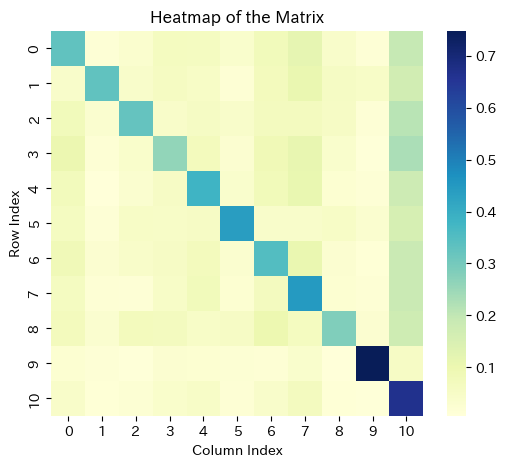


時点 2 から 3 への遷移行列:
各状態のエントロピー：[2.1203685  1.60294712 1.81718344 2.1223946  2.08684201 1.62209908
 2.11202642 2.11619164 1.84624387 1.02550488 2.22064417]

全体のエントロピー1.8811314292209678
      0     1     2     3     4     5     6     7     8     9     10
0  0.319 0.014 0.030 0.077 0.097 0.045 0.103 0.094 0.037 0.018 0.165
1  0.047 0.301 0.064 0.054 0.044 0.037 0.146 0.099 0.040 0.040 0.128
2  0.059 0.028 0.328 0.063 0.049 0.033 0.084 0.090 0.052 0.019 0.195
3  0.086 0.020 0.034 0.301 0.066 0.035 0.086 0.115 0.029 0.024 0.204
4  0.067 0.017 0.030 0.069 0.362 0.032 0.083 0.107 0.023 0.020 0.190
5  0.064 0.020 0.032 0.055 0.070 0.412 0.048 0.068 0.038 0.033 0.161
6  0.079 0.027 0.040 0.067 0.074 0.018 0.381 0.088 0.045 0.013 0.167
7  0.052 0.021 0.024 0.060 0.071 0.017 0.063 0.477 0.021 0.021 0.172
8  0.095 0.029 0.057 0.049 0.064 0.051 0.095 0.091 0.294 0.016 0.159
9  0.020 0.020 0.007 0.020 0.032 0.015 0.019 0.040 0.010 0.759 0.059
10 0.050 0.012 0.025 0.052 0.052 0.019 0.050 0.076 0.021 0

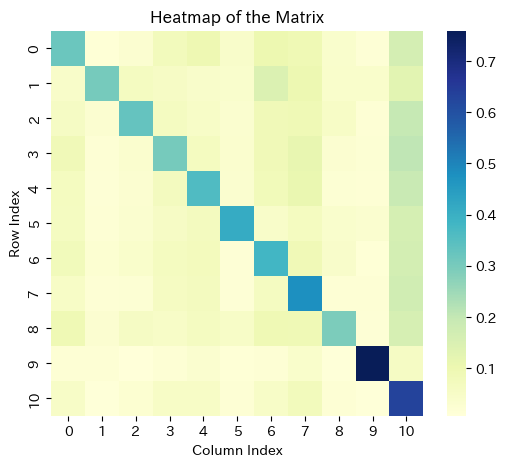


時点 3 から 4 への遷移行列:
各状態のエントロピー：[2.13824037 1.66731788 1.87803537 2.14979743 2.06240298 1.64602807
 2.154777   2.11842011 1.87803206 1.02497407 2.22745376]

全体のエントロピー1.9041344630863362
      0     1     2     3     4     5     6     7     8     9     10
0  0.323 0.021 0.032 0.081 0.066 0.032 0.084 0.104 0.045 0.015 0.197
1  0.060 0.326 0.057 0.049 0.055 0.031 0.078 0.076 0.044 0.039 0.185
2  0.070 0.033 0.314 0.072 0.048 0.025 0.091 0.092 0.046 0.013 0.196
3  0.104 0.025 0.037 0.271 0.076 0.035 0.088 0.094 0.036 0.017 0.218
4  0.070 0.017 0.026 0.054 0.364 0.037 0.081 0.112 0.029 0.027 0.183
5  0.065 0.017 0.031 0.045 0.071 0.416 0.065 0.083 0.036 0.031 0.141
6  0.083 0.044 0.041 0.076 0.071 0.036 0.344 0.095 0.043 0.016 0.152
7  0.051 0.021 0.024 0.063 0.077 0.025 0.068 0.474 0.022 0.021 0.153
8  0.085 0.049 0.059 0.068 0.049 0.047 0.088 0.090 0.288 0.022 0.156
9  0.026 0.016 0.017 0.015 0.027 0.016 0.026 0.038 0.008 0.748 0.063
10 0.042 0.015 0.029 0.049 0.047 0.022 0.048 0.080 0.021 0

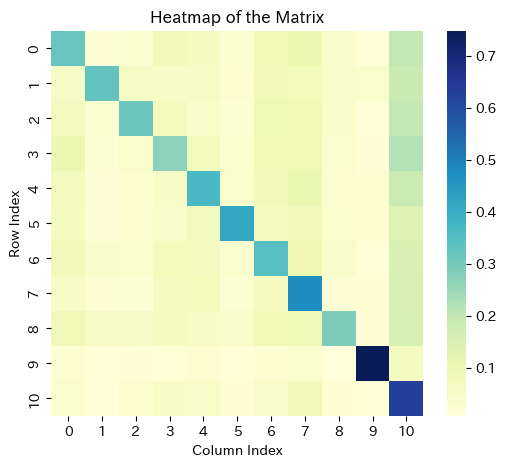


時点 4 から 5 への遷移行列:
各状態のエントロピー：[2.15482459 1.69173846 1.90773255 2.13516509 2.06455981 1.67607843
 2.14275725 2.1390654  1.79971859 1.02661906 2.23490846]

全体のエントロピー1.9066516079368194
      0     1     2     3     4     5     6     7     8     9     10
0  0.332 0.029 0.031 0.073 0.076 0.038 0.083 0.094 0.035 0.018 0.190
1  0.055 0.335 0.037 0.040 0.042 0.026 0.084 0.112 0.026 0.048 0.194
2  0.076 0.045 0.268 0.059 0.051 0.037 0.092 0.080 0.029 0.031 0.233
3  0.111 0.027 0.036 0.233 0.084 0.036 0.087 0.121 0.025 0.014 0.226
4  0.084 0.017 0.033 0.049 0.372 0.039 0.063 0.126 0.029 0.020 0.168
5  0.064 0.027 0.037 0.050 0.065 0.397 0.053 0.087 0.034 0.028 0.157
6  0.084 0.037 0.038 0.057 0.087 0.039 0.321 0.113 0.028 0.014 0.181
7  0.059 0.020 0.023 0.043 0.065 0.016 0.056 0.486 0.024 0.015 0.191
8  0.092 0.031 0.050 0.054 0.075 0.045 0.099 0.085 0.264 0.021 0.183
9  0.027 0.019 0.008 0.011 0.025 0.019 0.017 0.047 0.011 0.756 0.059
10 0.053 0.017 0.026 0.039 0.045 0.017 0.047 0.075 0.013 0

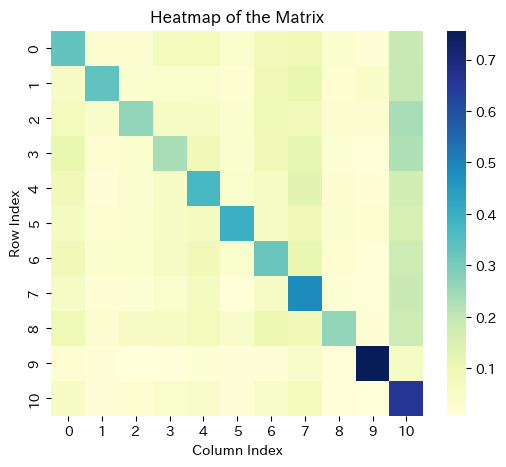


時点 5 から 6 への遷移行列:
各状態のエントロピー：[2.17496629 1.60587733 1.86350002 2.10615946 2.11141148 1.67589835
 2.15782868 2.09545236 1.67844908 1.0091886  2.2244246 ]

全体のエントロピー1.882105113310313
      0     1     2     3     4     5     6     7     8     9     10
0  0.359 0.019 0.029 0.073 0.082 0.031 0.074 0.123 0.020 0.021 0.169
1  0.067 0.325 0.062 0.050 0.048 0.032 0.097 0.075 0.018 0.042 0.183
2  0.065 0.035 0.319 0.044 0.076 0.037 0.087 0.089 0.027 0.015 0.206
3  0.112 0.015 0.041 0.254 0.081 0.035 0.107 0.122 0.020 0.015 0.200
4  0.091 0.018 0.035 0.050 0.356 0.034 0.082 0.116 0.024 0.022 0.172
5  0.094 0.015 0.026 0.054 0.071 0.416 0.068 0.057 0.017 0.042 0.140
6  0.115 0.041 0.055 0.056 0.079 0.032 0.309 0.100 0.033 0.014 0.166
7  0.074 0.018 0.021 0.040 0.075 0.027 0.062 0.499 0.014 0.015 0.155
8  0.112 0.042 0.059 0.040 0.068 0.053 0.080 0.078 0.247 0.013 0.209
9  0.031 0.020 0.011 0.016 0.023 0.020 0.012 0.043 0.007 0.755 0.060
10 0.056 0.011 0.025 0.040 0.051 0.022 0.041 0.079 0.016 0.

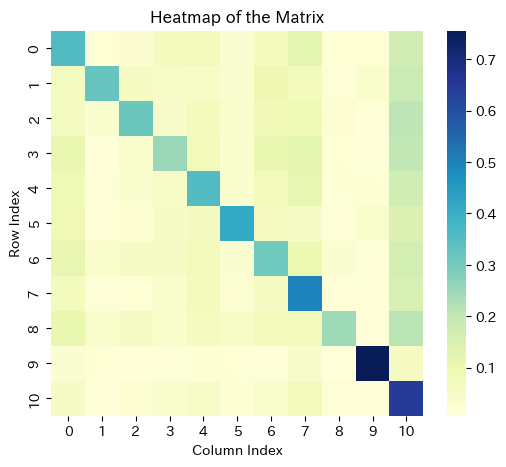


時点 6 から 7 への遷移行列:
各状態のエントロピー：[2.18091484 1.57581468 1.809486   2.106307   2.07381735 1.65894058
 2.06836736 2.11665006 1.789982   0.8884566  2.22921848]

全体のエントロピー1.8634504490147288
      0     1     2     3     4     5     6     7     8     9     10
0  0.325 0.021 0.033 0.064 0.072 0.038 0.090 0.112 0.030 0.020 0.195
1  0.082 0.380 0.027 0.045 0.055 0.027 0.082 0.075 0.032 0.032 0.164
2  0.073 0.065 0.312 0.035 0.046 0.039 0.085 0.088 0.039 0.011 0.207
3  0.143 0.027 0.035 0.201 0.068 0.039 0.081 0.118 0.042 0.009 0.237
4  0.086 0.016 0.025 0.033 0.354 0.028 0.071 0.154 0.024 0.016 0.193
5  0.079 0.025 0.037 0.022 0.074 0.410 0.040 0.071 0.031 0.027 0.184
6  0.084 0.030 0.040 0.060 0.062 0.034 0.354 0.109 0.034 0.013 0.179
7  0.067 0.023 0.023 0.035 0.072 0.025 0.050 0.489 0.016 0.018 0.183
8  0.088 0.028 0.054 0.049 0.073 0.041 0.073 0.104 0.282 0.018 0.189
9  0.025 0.015 0.011 0.014 0.021 0.019 0.018 0.030 0.010 0.779 0.056
10 0.051 0.014 0.025 0.030 0.048 0.017 0.032 0.079 0.016 0

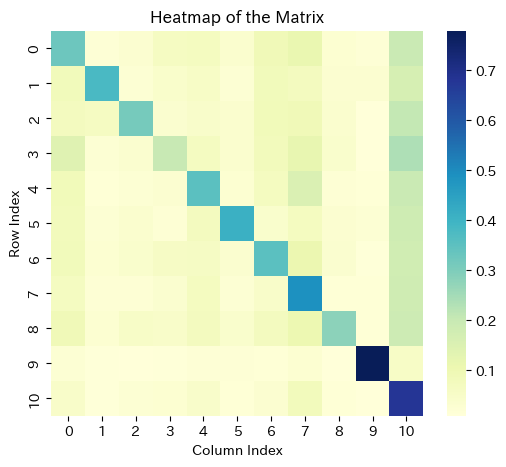


時点 7 から 8 への遷移行列:
各状態のエントロピー：[2.16647595 1.48123943 1.77016771 2.10219331 2.0596296  1.6158708
 2.06364824 2.14245558 1.76089333 0.96608819 2.23705198]

全体のエントロピー1.8514285560184751
      0     1     2     3     4     5     6     7     8     9     10
0  0.347 0.018 0.029 0.062 0.066 0.041 0.085 0.138 0.029 0.017 0.168
1  0.073 0.340 0.044 0.033 0.048 0.033 0.106 0.129 0.015 0.029 0.151
2  0.071 0.043 0.291 0.035 0.050 0.033 0.081 0.093 0.048 0.023 0.231
3  0.115 0.016 0.022 0.206 0.062 0.042 0.102 0.125 0.033 0.020 0.258
4  0.076 0.018 0.023 0.036 0.380 0.036 0.068 0.124 0.026 0.018 0.196
5  0.086 0.012 0.029 0.032 0.065 0.432 0.048 0.071 0.023 0.027 0.174
6  0.111 0.031 0.034 0.045 0.081 0.028 0.379 0.102 0.035 0.010 0.144
7  0.070 0.017 0.023 0.034 0.076 0.019 0.052 0.494 0.018 0.014 0.183
8  0.099 0.014 0.063 0.038 0.079 0.036 0.072 0.095 0.264 0.020 0.221
9  0.026 0.019 0.005 0.018 0.028 0.019 0.014 0.036 0.009 0.743 0.082
10 0.048 0.013 0.016 0.034 0.051 0.019 0.040 0.085 0.013 0.

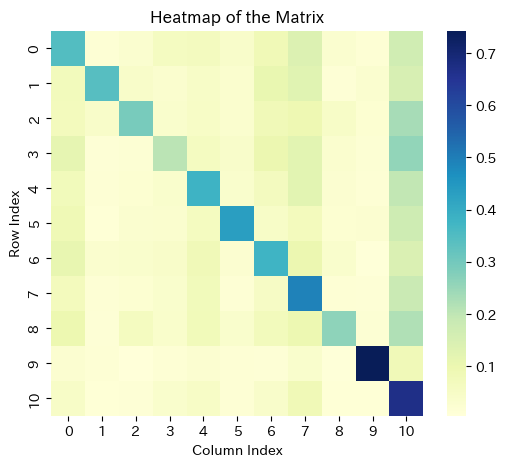


時点 8 から 9 への遷移行列:
各状態のエントロピー：[2.15231261 1.48524682 1.74521753 2.10149766 2.04787899 1.75695937
 2.14522659 2.12491118 1.70028276 1.04421539 2.22911816]

全体のエントロピー1.8666242782712361
      0     1     2     3     4     5     6     7     8     9     10
0  0.357 0.019 0.034 0.061 0.089 0.044 0.070 0.112 0.021 0.019 0.174
1  0.057 0.330 0.064 0.031 0.033 0.024 0.092 0.106 0.014 0.054 0.196
2  0.071 0.028 0.354 0.047 0.022 0.045 0.104 0.079 0.053 0.008 0.189
3  0.115 0.015 0.024 0.247 0.076 0.043 0.085 0.099 0.027 0.025 0.244
4  0.088 0.012 0.027 0.055 0.370 0.042 0.075 0.111 0.025 0.018 0.177
5  0.080 0.017 0.047 0.055 0.095 0.377 0.062 0.077 0.017 0.029 0.144
6  0.092 0.031 0.044 0.046 0.086 0.035 0.340 0.110 0.033 0.014 0.169
7  0.076 0.019 0.022 0.038 0.067 0.019 0.061 0.490 0.017 0.019 0.171
8  0.097 0.019 0.033 0.050 0.086 0.050 0.093 0.088 0.266 0.024 0.195
9  0.026 0.017 0.008 0.019 0.029 0.019 0.023 0.045 0.005 0.752 0.057
10 0.053 0.015 0.023 0.038 0.046 0.021 0.045 0.079 0.020 0

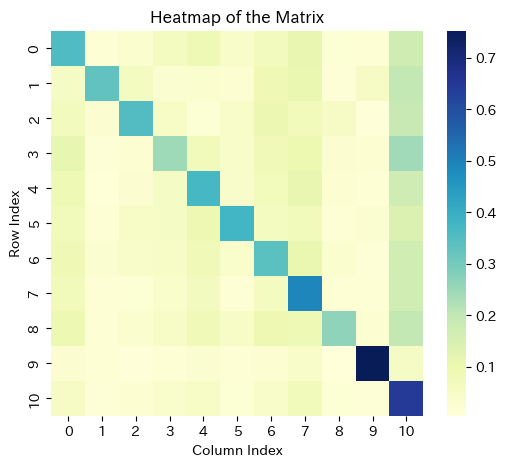


時点 9 から 10 への遷移行列:
各状態のエントロピー：[2.17898571 1.42201067 1.77961569 2.07652902 2.06726499 1.7116204
 2.07740704 2.16449715 1.75459441 1.05936054 2.24579374]

全体のエントロピー1.8670617589822773
      0     1     2     3     4     5     6     7     8     9     10
0  0.340 0.022 0.026 0.061 0.079 0.038 0.066 0.126 0.026 0.025 0.191
1  0.080 0.345 0.045 0.038 0.045 0.025 0.052 0.095 0.012 0.058 0.205
2  0.063 0.031 0.305 0.038 0.053 0.027 0.082 0.104 0.034 0.019 0.243
3  0.113 0.017 0.034 0.226 0.077 0.044 0.062 0.126 0.024 0.024 0.253
4  0.099 0.005 0.024 0.039 0.358 0.050 0.074 0.121 0.029 0.013 0.189
5  0.076 0.018 0.023 0.030 0.079 0.388 0.051 0.098 0.042 0.026 0.169
6  0.108 0.028 0.043 0.045 0.072 0.038 0.328 0.112 0.024 0.016 0.187
7  0.073 0.023 0.025 0.025 0.059 0.024 0.050 0.486 0.019 0.028 0.187
8  0.106 0.021 0.043 0.054 0.064 0.031 0.090 0.113 0.255 0.019 0.203
9  0.022 0.011 0.008 0.018 0.018 0.022 0.014 0.045 0.009 0.765 0.065
10 0.057 0.011 0.021 0.035 0.050 0.022 0.038 0.073 0.014 0

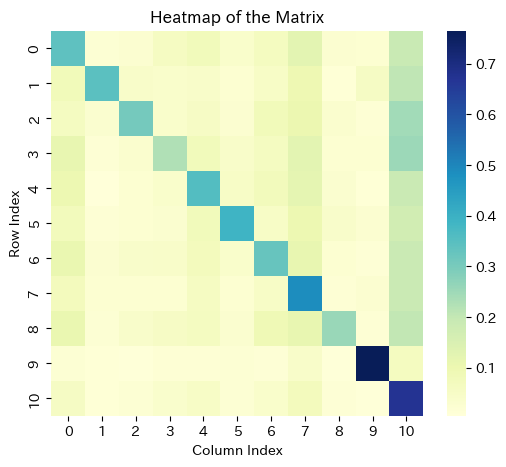


時点 10 から 11 への遷移行列:
各状態のエントロピー：[2.15511249 1.46148595 1.75888474 2.10177883 2.00873232 1.72682313
 2.05719098 2.18935364 1.86591027 1.0226066  2.21329318]

全体のエントロピー1.8691974670648284
      0     1     2     3     4     5     6     7     8     9     10
0  0.351 0.016 0.034 0.056 0.078 0.034 0.075 0.136 0.032 0.016 0.173
1  0.077 0.348 0.034 0.055 0.034 0.034 0.050 0.150 0.021 0.053 0.142
2  0.066 0.029 0.356 0.046 0.031 0.040 0.091 0.108 0.035 0.026 0.173
3  0.128 0.019 0.023 0.231 0.073 0.049 0.075 0.128 0.034 0.016 0.225
4  0.074 0.020 0.029 0.047 0.373 0.034 0.064 0.135 0.027 0.023 0.175
5  0.081 0.010 0.032 0.048 0.057 0.425 0.029 0.078 0.041 0.028 0.170
6  0.102 0.026 0.048 0.046 0.071 0.043 0.336 0.124 0.042 0.012 0.151
7  0.074 0.020 0.027 0.030 0.070 0.025 0.058 0.500 0.022 0.017 0.157
8  0.091 0.032 0.056 0.049 0.093 0.051 0.054 0.142 0.250 0.020 0.162
9  0.021 0.011 0.013 0.011 0.017 0.023 0.024 0.054 0.005 0.768 0.054
10 0.055 0.013 0.027 0.036 0.046 0.026 0.039 0.088 0.023

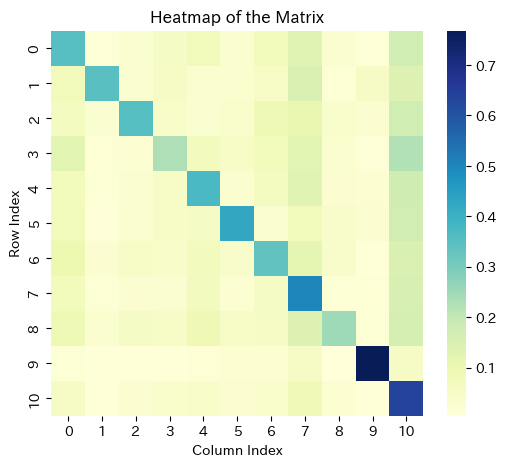

In [43]:
# 時点ごとの遷移行列を作成
import seaborn as sns
from scipy.stats import entropy
transition_matrices = create_time_dependent_transition_matrices(transtion_data)

# 結果の表示
for time, matrix in transition_matrices.items():
    print(f"\n時点 {time} から {time+1} への遷移行列:")
    print(f"各状態のエントロピー：{entropy(matrix)}")
    print()
    print(f"全体のエントロピー{np.mean(entropy(matrix))}")
    
    df_tra = pd.DataFrame(matrix).round(3)
    print(df_tra)
    plt.figure(figsize=(6, 5))
    matrix = pd.DataFrame(matrix)
    sns.heatmap(df_tra, annot=False ,cmap='YlGnBu')
    plt.title('Heatmap of the Matrix')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    
    # ヒートマップの表示
    plt.show()

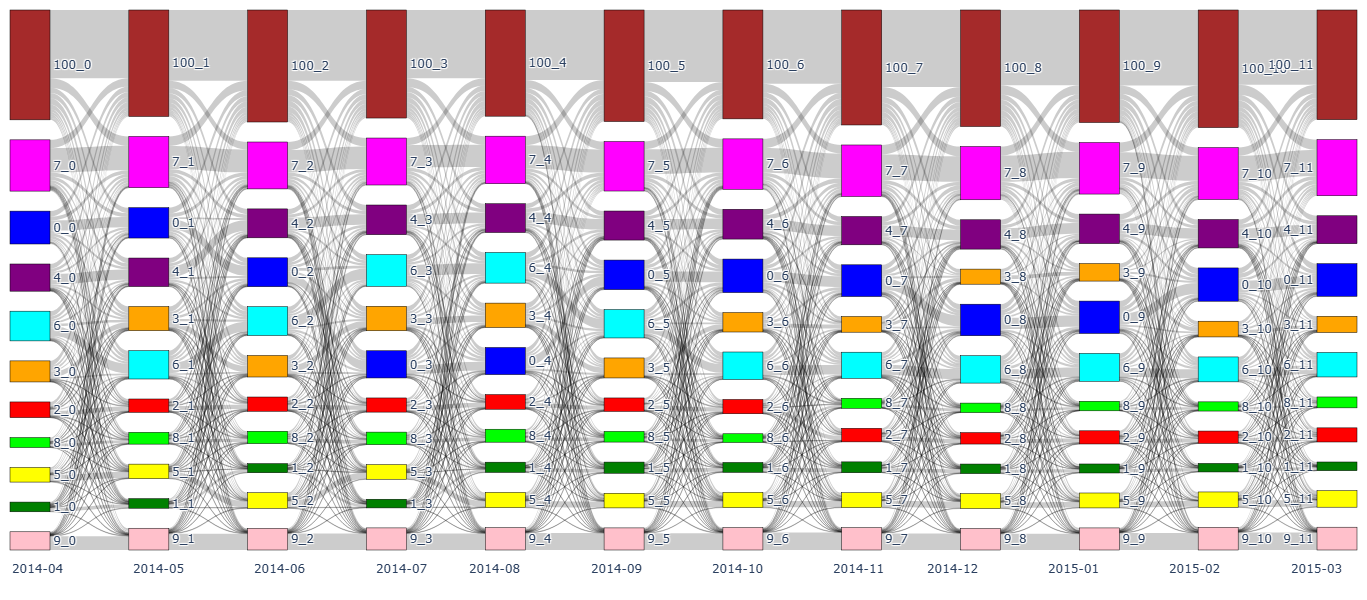

In [70]:
import pandas as pd
import plotly.graph_objects as go

def create_color_mapping():
    return {
        '0': 'blue', '1': 'green', '2': 'red', '3': 'orange',
        '4': 'purple', '5': 'yellow', '6': 'cyan', '7': 'magenta',
        '8': 'lime', '9': 'pink', '100':'brown'
    }

def prepare_sankey_data(source, target, values_list):
    unique_nodes = list(set(source + target))
    node_indices = {node: i for i, node in enumerate(unique_nodes)}

    color_mapping = create_color_mapping()
    color_list = [color_mapping[node.split('_')[0]] for node in unique_nodes]

    source_indices = [node_indices[node] for node in source]
    target_indices = [node_indices[node] for node in target]

    return unique_nodes, color_list, source_indices, target_indices

def create_sankey_diagram_with_dates(source, target, values_list, dates):
    unique_nodes, color_list, source_indices, target_indices = prepare_sankey_data(source, target, values_list)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=40,
            line=dict(color="black", width=0.5),
            label=unique_nodes,
            color=color_list
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values_list
        )
    )])

    # 各列に異なる年月を追加
    annotations = []
    for i, date in enumerate(column_dates):
        annotations.append(
            dict(
                text=date,  # 表示する年月
                x= i * 0.09,  # x軸を各列に対応（間隔を調整）
                y=-0.05,  # y軸の位置をグラフ上部に固定
                showarrow=False,
                font=dict(size=12),
                xref="paper",  # x座標を「描画エリア」で相対指定
                yref="paper"   # y座標を「描画エリア」で相対指定
            )
        )

    fig.update_layout(
        annotations=annotations,  # 全ての注釈を追加
        width=2000,
        height=600,
        margin=dict(l=10, r=10, t=10, b=50)  # 余白を調整
    )

    return fig


# 使用例
dates =pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()
fig = create_sankey_diagram_with_dates(source, target, values_list, dates)

# 保存時の余白を最小化
fig.write_image("sankey_conv.png", format="png", scale=2, width=2000, height=650)  # 余白を考慮したサイズ
fig.show()